## Speed dating data-set
#### Joris Rombouts - November 2017

### 1.3 Feature Engineering

### <font color="green">imports, preparation and configuration</font>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree, preprocessing, metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# imports needed for the visualization and exportation of visualizations
import graphviz as gv # not included in the standard anaconda installer (can be found in the Anaconda Navigator)
import pydotplus # not included in anaconda at all (use pip/conda install pydotplus in cmd/conda prompt etc)
import io
from scipy import misc

In [3]:
from IPython.core.display import HTML # markdown cell styling and enabling/disabling warning messages
HTML("""
<style>
div.text_cell_render h1 {
font-size: 1.6em;
line-height:1.2em;
}

div.text_cell_render h2 { 
margin-bottom: -0.4em;
}

div.text_cell_render { 
font-size:1.2em;
line-height:1.2em;
font-weight:500;
}

div.text_cell_render p, li {
color:Navy;
}

</style>

<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.
""") 

In [4]:
df = pd.read_csv("speed_dating_assignment.csv")
df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


The model should be trained to build the class attribute <i>dec</i>. To help and improve the models, one can introduce new (calculated) features. These features should optimize the performance metric. Just as in 1.2, the attributes with a lot of missing values (NaN) are not very usefull for the model. Because this is a small size of dataset, the NaN values won't be filled in. 
This improved model is built on the model of 1.2, with some extra new calculated features. For introducing new calculated features, the attributes of the partner need to be accessed by cross-referencing it (using <i>pid == iid </i>). In addition to the attributes that are used in 1.2, the following features are added to the dataframe:

* <b>age_diff</b> <i>absolute difference between subject's age and partners age (age_o, see 1.1)</i> As concluded in 1.1, the number of decisions that a participant wanted to see a partner again was higher when there was a low age difference between the two. One can also imagine that the lower the age difference, people find it easier to communicate. Therefore, it could be that this is a important attribute on which the decision tree can split. 
* <b>attr_o</b> <i>rating by partner the night of the event, for all six attributes (attr,sinc,intel,fun,amb and shar)</i> Each participant rate their partner on six attributes on a scale of 1 -10 (1=awful, 10 = great). Therefore, the higher each partner scores, the better. So adding all these ratings to a total rating , which could be maximum a score of 60, could be a good indicidation whether the participant want to see their partner again. Note that these ratings are the same for all waves (except from the other ratings), so we don't need to convert them. 
* <b>race_equals</b> <i>boolean value, which is True if the race of the partner equals the race of the participant and False otherwise</i> One can imagine that people from the same race have similarities in their daily habits and culture in general. Therefore it could be interesting to see when participant and partner are from the same race, this increases the chance of seeing each other again. 
* <b>goal_equals</b> <i>boolean value, which is True if the goal of the partner equals the goal of the participant and False otherwise </i> When both people go on date with the same purpose, for example "looking for a serious relationship" or "to get a date", this could be increasing the fact that they wanted to see their partner again or not. When subjects have a different or the same primary goal, this could influence their decision. 

In [5]:
df_o = df.copy()
df_o = df_o.filter(items=['iid', 'age', 'race', 'goal'])
df_o.rename(columns={'iid': 'pid', 'age': 'age_o', 'race': 'race_partner', 'goal':'goal_partner'}, inplace = True)
df_o = df_o.drop_duplicates()

df_new = pd.merge(df, df_o, on=['pid'], how = 'left')

In [6]:
df =df_new.copy()

Just as in 1.2, only the missing values of age are filled in by the mean of the column. We don't do this for the other attributes, because this will affect the correctness of the model too much , as explained earlier in 1.2.

In [7]:
df = df[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'gender', 'order','goal', 'field_cd', 'date','age', 'go_out', 'imprace', 'imprelig', 'dec', 'age_o', 'race', 'pid', 'iid', 'race_partner', 'goal_partner']]
df.age.fillna(df.age.median(), inplace = True)
print(df.shape)
df.info()

(8378, 22)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8378 entries, 0 to 8377
Data columns (total 22 columns):
attr            8176 non-null float64
sinc            8101 non-null float64
intel           8082 non-null float64
fun             8028 non-null float64
amb             7666 non-null float64
shar            7311 non-null float64
gender          8378 non-null int64
order           8378 non-null int64
goal            8299 non-null float64
field_cd        8296 non-null float64
date            8281 non-null float64
age             8378 non-null float64
go_out          8299 non-null float64
imprace         8299 non-null float64
imprelig        8299 non-null float64
dec             8378 non-null int64
age_o           8274 non-null float64
race            8315 non-null float64
pid             8368 non-null object
iid             8378 non-null int64
race_partner    8305 non-null float64
goal_partner    8289 non-null float64
dtypes: float64(17), int64(4), object(1)
memory usage: 

In [8]:
df = df.dropna().reset_index(drop=True)

### <font color="green">Calculating new features</font>

This paragraph covers the calculations of the new features that are introduced in the dataframe. The <i>attr_o</i> attribute is calculated by summing up all the six attributes. After that these attributes are deleted from the dataframe, so that they won't have influence anymore on the predictive model will be created in the next paragraph. The other calculations are rather straightforward.

In [9]:
df['attr_o'] = df['attr'] + df['sinc'] + df['intel'] + df['fun'] + df['amb'] + df['shar']
df = df.drop(['attr', 'sinc', 'intel', 'fun', 'shar', 'amb'], axis = 1)

In [10]:
df['age_diff'] = abs(df['age'] - df['age_o'])

In [11]:
df['race_equals'] = (df['race'] == df['race_partner'])

In [12]:
df['goal_equals'] = df.apply(lambda r: r.goal == r.goal_partner, axis = 1)

In [13]:
df = df[['gender', 'order','goal', 'field_cd', 'date','age', 'go_out', 'imprace', 'imprelig', 'dec','age_diff', 'attr_o', 'goal_equals']]
df.head()

,gender,order,goal,field_cd,date,age,go_out,imprace,imprelig,dec,age_diff,attr_o,goal_equals
0,0,4,2.0,1.0,7.0,21.0,1.0,2.0,4.0,1,6.0,40.0,False
1,0,3,2.0,1.0,7.0,21.0,1.0,2.0,4.0,1,1.0,41.0,False
2,0,10,2.0,1.0,7.0,21.0,1.0,2.0,4.0,1,1.0,42.0,True
3,0,5,2.0,1.0,7.0,21.0,1.0,2.0,4.0,1,2.0,42.0,True
4,0,7,2.0,1.0,7.0,21.0,1.0,2.0,4.0,1,3.0,37.0,False


Since also this model needs to be trained for two seperate genders (males and females), the data is seperated into a dataframe for the male daters and a data frame for the female daters.

In [14]:
male_subjects = df[df.gender == 1]
female_subjects = df[df.gender == 0]
male_subjects.shape, female_subjects.shape

((3455, 13), (3384, 13))

There are 3455 records in the data set of the male subjects and 3384 records in the data set of the female subjects. Not that for both the male and female dataframe these are less records than in 1.2. This is because this model includes extra attributes (<i>race</i>, <i>goal</i> and all the six attributes). These attributes also contained some NaN values, which were dropped.  

### <font color="green">Training the models</font>

The rows are shuffled to ensure a fair split into training and test data. The same steps as in 1.2 are repeated.

In [15]:
male_subjects_shuffle = male_subjects.sample(frac=1).reset_index(drop=True) # shuffle rows
female_subjects_shuffle = female_subjects.sample(frac=1).reset_index(drop=True)

In [16]:
male_x_data = male_subjects_shuffle.drop('dec', axis = 1) # dec is target attribute
female_x_data = female_subjects_shuffle.drop('dec', axis = 1)
male_labels = male_subjects_shuffle['dec']
female_labels = female_subjects_shuffle['dec']

The data is split into 80% training data and 20% test data.

In [17]:
male_x_train, male_x_test, male_y_train, male_y_test = train_test_split(male_x_data, male_labels, test_size = 0.2)
female_x_train, female_x_test, female_y_train, female_y_test = train_test_split(female_x_data, female_labels, test_size = 0.2)

To compare the models to each other and to the models using only the raw features (1.2), decision tree learning is going to be used to train the models. The target variable <i>dec</i> is unchanged.

In [18]:
dec_tree_male = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 8, min_samples_split = 50, min_samples_leaf = 12)
dec_tree_female = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 8, min_samples_split = 50, min_samples_leaf = 12)
# build decision tree classifiers from the training sets
dec_tree_male.fit(male_x_train, male_y_train)
dec_tree_female.fit(female_x_train, female_y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=12,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

### <font color="green">Visualizing the models</font>

The next function is only for visualizing the decision trees in a nice way.

In [19]:
def visualize_tree(dec_tree, path, classnames, feat_names):
    dfile = io.StringIO()
    tree.export_graphviz(dec_tree, out_file = dfile, feature_names = feat_names)
    pydotplus.graph_from_dot_data(dfile.getvalue()).write_png(path)
    i = misc.imread(path)
    plt.imshow(i)

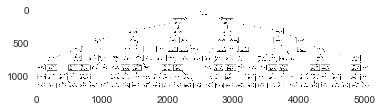

In [20]:
male_col_names = dec_tree_male.classes_
male_feature_names = male_subjects.columns[0:(male_subjects.shape[1] - 1)] # the features (attributes) used in the model
visualize_tree(dec_tree_male, "male_decision_tree(1.3).png", male_col_names, male_feature_names)

See Appendix A.3 for the full image (uncropped)

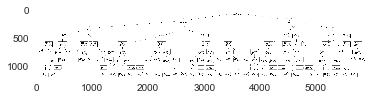

In [21]:
female_col_names = dec_tree_female.classes_
female_feature_names = female_subjects.columns[0:(female_subjects.shape[1] - 1)] # the features (attributes) used in the model
visualize_tree(dec_tree_female, "female_decision_tree(1.3).png", female_col_names, female_feature_names)

See Appendix A.4 for the full image (uncropped)

### <font color="green">Evaluating the performance of the models</font>

In [22]:
pred_male = dec_tree_male.predict(male_x_test) # predicting 'dec' for data which the model has not seen yet
print("Accuracy score: ", metrics.accuracy_score(male_y_test, pred_male))

Accuracy score:  0.730824891462


In [23]:
pred_female = dec_tree_female.predict(female_x_test) # predicting 'dec' for data which the model has not seen yet
print("Accuracy score: ", metrics.accuracy_score(female_y_test, pred_female))

Accuracy score:  0.716395864106


The accuracy of a predictive model has its limitations. It really depends on the randomness of how the data is shuffled and many other factors. A performance matrix contains the Precision and Recall performance of the decision tree, which gives far more information.

In [24]:
print(metrics.classification_report(male_y_test, pred_male))

             precision    recall  f1-score   support

          0       0.73      0.75      0.74       348
          1       0.74      0.71      0.72       343

avg / total       0.73      0.73      0.73       691



percentage "dec = 0" in the male data set:  50.68 %
percentage "dec = 1" in the male data set:  49.32 %


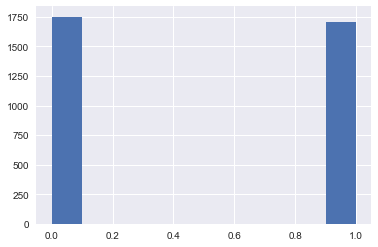

In [25]:
print('percentage "dec = 0" in the male data set: ', round((male_subjects_shuffle.loc[male_subjects_shuffle.dec == 0].shape[0] / male_subjects_shuffle.dec.values.shape[0]) * 100, 2), "%")
print('percentage "dec = 1" in the male data set: ', round((male_subjects_shuffle.loc[male_subjects_shuffle.dec == 1].shape[0] / male_subjects_shuffle.dec.values.shape[0]) * 100, 2), "%")
plt.hist(male_subjects_shuffle.dec)
plt.show()

The distribution of the binary values 0 and 1 in the <i>dec</i> column roughly fair distributed. So approximately half of the males expressed in their dates to see the partner again, while the other half of the males expressed in their date.

<b> Male model</b>
The support of this model is (368/(368+323))*100% = 53%, which is not entirely in line with the distribution of the dec attribute in the complete male data set (50.68%). For both dec = 0 and dec = 1 the <i>precision</i> and <i>recall</i> metrics is going to be evaluated.
* <b>for dec = 0</b> The classifier has a precision of 76% and a recall of 68%. This means that the classifier was able to classify 68% of the records with value 0 for 0, with the correct value of 0. So in more than two-third of the records the model predicts right for dec = 0. However it still happens that 24% of the records are not correctly classified. In 24% of the cases the classifier does not classifies dec = 1 records with dec = 0.
* <b>for dec = 1</b> The classifier has a precision of 68% and a recall of 75%. The recall is a little higher compared to dec = 0. The classifier was not able to label a record with dec = 1, when the originally record had dec = 0 in 68% of the records. This is lower than the precision of dec = 0. The recall is quite good, in 75% of the records the classifier was able to lable dec = 1, when the original value is 1. 

One can conclude that the classifier is better in recognizing records that lead to a decision to see the partner again, compared to cases that lead to a decision where the subjects not want to see the partner again.

In [26]:
print(metrics.classification_report(female_y_test, pred_female))

             precision    recall  f1-score   support

          0       0.74      0.84      0.79       426
          1       0.65      0.51      0.57       251

avg / total       0.71      0.72      0.71       677



percentage "dec = 0" in the female data set:  62.8 %
percentage "dec = 1" in the female data set:  37.2 %


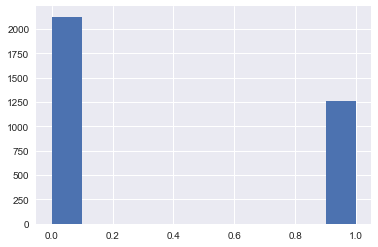

In [27]:
print('percentage "dec = 0" in the female data set: ', round((female_subjects_shuffle.loc[female_subjects_shuffle.dec == 0].shape[0] / female_subjects_shuffle.dec.values.shape[0]) * 100, 2), "%")
print('percentage "dec = 1" in the female data set: ', round((female_subjects_shuffle.loc[female_subjects_shuffle.dec == 1].shape[0] / female_subjects_shuffle.dec.values.shape[0]) * 100, 2), "%")
plt.hist(female_subjects_shuffle.dec)
plt.show()

The distribution of the values 0 and 1 in the <i>dec</i> column is not equal. The female subjects expressed in approximately 63% of the dates not to see the respective date partner again. While in only 37% of the dates they wish to see their partner again. Compared to the male subjects, female subjects are more critical in their decision.

### <font color="green">Comparing the differences among the models</font>

<b>Female model</b>
Support of the target attribute in the test data set (427/(427+250)) * 100% = 63% for dec = 0. This is in line with the distribution of the dec attribute in the complete female data set. The train and test splits are , therefore, descent representatives of the sample in the original data set. Next, the precision and recall metric are going to be evaluated.

* <b>for dec = 0</b> the classifier has a precision of 0.76 and a recall of 0.83. So the classifier was able not to label a record with dec = 0, when the record originally had dec = 1 in 76% of the cases. Also, it was able to classfiy 83% of the records correctly for dec = 0. So in both cases the classifier is quite accurate in predicting records which should have dec = 0.  Only in 24% of the record it classifies dec = 1 records with dec = 0. 
* <b>for dec = 1</b> the classifier has a precision of 0.66 and a recall of 0.55. The recall of dec = 1 is significantly lower compared to dec = 0. It was  able not to label a record with dec = 1, when the record originally had dec = 0 in 66% of the cases, which is 10% lower compared to dec = 0. Furthermore, it was able to classify 55% of the records with the correct value for dec = 1. 

The classifier is significantly better in recognizing when a date not wanted to see their partner again, compared to cases when a date want to see their date again. However, there are far more subjects that decide to not see their partner again. Therefore the classifier has less records to learn from. Also, the test data contains less dec = 1 records. Therefore a low precision will quickly lead to a lower recall.

### <font color="green">Comparing the differences among the models (raw featurs vs calculated features)</font>

## Speed dating data-set
#### Bart v. Helvert - November 2017

### 2.1 Unisex model

### <font color="green">Imports, preparation and configuration</font>

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree, preprocessing, metrics
import matplotlib.pyplot as plt
%matplotlib inline

import io
import graphviz as gv # not included in the standard anaconda installer (can be found in the Anaconda Navigator)
import pydotplus # not included in anaconda at all (use pip/conda install pydotplus in cmd/conda prompt etc)
from scipy import misc

In [29]:
# Loads the data
unisex = pd.read_csv("speed_dating_assignment.csv")

In [30]:
# Visualizes a decision tree and stores it
def visualize_tree(dec_tree, path, classnames, feat_names):
    dfile = io.StringIO()
    tree.export_graphviz(dec_tree, out_file = dfile, feature_names = feat_names)
    pydotplus.graph_from_dot_data(dfile.getvalue()).write_png(path)
    i = misc.imread(path)
    plt.imshow(i)

### <font color="green">Preparing the data</font>

To make a valid comparison later in 2.2 the introduced features for the unisex model are the same as for the gender based model described in 1.3. We introduce the following new variables:

* <b>age_diff</b> <i>absolute difference between subject's age and partners age (age_o, see 1.1)</i> As concluded in 1.1, the number of decisions that a participant wanted to see a partner again was higher when there was a low age difference between the two. One can also imagine that the lower the age difference, people find it easier to communicate. Therefore, it could be that this is a important attribute on which the decision tree can split. 
* <b>attr_o</b> <i>rating by partner the night of the event, for all six attributes (attr,sinc,intel,fun,amb and shar)</i> Each participant rate their partner on six attributes on a scale of 1 -10 (1=awful, 10 = great). Therefore, the higher each partner scores, the better. So adding all these ratings to a total rating , which could be maximum a score of 60, could be a good indicidation whether the participant want to see their partner again. Note that these ratings are the same for all waves (except from the other ratings), so we don't need to convert them. 
* <b>race_equals</b> <i>boolean value, which is True if the race of the partner equals the race of the participant and False otherwise</i> One can imagine that people from the same race have similarities in their daily habits and culture in general. Therefore it could be interesting to see when participant and partner are from the same race, this increases the chance of seeing each other again. 
* <b>goal_equals</b> <i>boolean value, which is True if the goal of the partner equals the goal of the participant and False otherwise </i> When both people go on date with the same purpose, for example "looking for a serious relationship" or "to get a date", this could be increasing the fact that they wanted to see their partner again or not. When subjects have a different or the same primary goal, this could influence their decision. 

In [31]:
unisex_o = unisex.copy()
unisex_o = unisex_o.filter(items=['iid', 'age', 'race', 'goal'])
unisex_o.rename(columns={'iid': 'pid', 'age': 'age_o', 'race': 'race_partner', 'goal':'goal_partner'}, inplace = True)
unisex_o = unisex_o.drop_duplicates()

unisex_new = pd.merge(unisex, unisex_o, on=['pid'], how = 'left')
unisex = unisex_new.copy()

Just as in 1.2, only the missing values of age are filled in by the mean of the column. We don't do this for the other attributes, because this will affect the correctness of the model too much , as explained earlier in 1.2.

In [32]:
unisex = unisex[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'gender', 'order','goal', 'field_cd', 'date','age', 'go_out', 'imprace', 'imprelig', 'dec', 'age_o', 'race', 'pid', 'iid', 'race_partner', 'goal_partner']]
unisex.age.fillna(unisex.age.median(), inplace = True)
print(unisex.shape)
unisex.info()

(8378, 22)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8378 entries, 0 to 8377
Data columns (total 22 columns):
attr            8176 non-null float64
sinc            8101 non-null float64
intel           8082 non-null float64
fun             8028 non-null float64
amb             7666 non-null float64
shar            7311 non-null float64
gender          8378 non-null int64
order           8378 non-null int64
goal            8299 non-null float64
field_cd        8296 non-null float64
date            8281 non-null float64
age             8378 non-null float64
go_out          8299 non-null float64
imprace         8299 non-null float64
imprelig        8299 non-null float64
dec             8378 non-null int64
age_o           8274 non-null float64
race            8315 non-null float64
pid             8368 non-null object
iid             8378 non-null int64
race_partner    8305 non-null float64
goal_partner    8289 non-null float64
dtypes: float64(17), int64(4), object(1)
memory usage: 

In [33]:
unisex = unisex.dropna().reset_index(drop=True)

### <font color="green">Calculating new features</font>

As described in 1.3 we calculate the new features mentioned above

In [34]:
unisex['attr_o'] = unisex['attr'] + unisex['sinc'] + unisex['intel'] + unisex['fun'] + unisex['amb'] + unisex['shar']
unisex = unisex.drop(['attr', 'sinc', 'intel', 'fun', 'shar', 'amb'], axis = 1)
unisex['age_diff'] = abs(unisex['age'] - unisex['age_o'])
unisex['race_equals'] = (unisex['race'] == unisex['race_partner'])
unisex['goal_equals'] = unisex.apply(lambda r: r.goal == r.goal_partner, axis = 1)
unisex = unisex[['gender', 'order','goal', 'field_cd', 'date','age', 'go_out', 'imprace', 'imprelig', 'dec','age_diff', 'attr_o', 'goal_equals']]
unisex.head()

,gender,order,goal,field_cd,date,age,go_out,imprace,imprelig,dec,age_diff,attr_o,goal_equals
0,0,4,2.0,1.0,7.0,21.0,1.0,2.0,4.0,1,6.0,40.0,False
1,0,3,2.0,1.0,7.0,21.0,1.0,2.0,4.0,1,1.0,41.0,False
2,0,10,2.0,1.0,7.0,21.0,1.0,2.0,4.0,1,1.0,42.0,True
3,0,5,2.0,1.0,7.0,21.0,1.0,2.0,4.0,1,2.0,42.0,True
4,0,7,2.0,1.0,7.0,21.0,1.0,2.0,4.0,1,3.0,37.0,False


### <font color="green">Training the model</font>

In [35]:
# Training the model
subjects_shuff_uni = unisex.sample(frac=1).reset_index(drop=True) # shuffle rows
x_data_uni = subjects_shuff_uni.drop('dec', axis = 1) # dec is target attribute
labels_uni = subjects_shuff_uni['dec']

Splitting the data into 80% training data and 20% test data

In [36]:
x_train_uni, x_test_uni, y_train_uni, y_test_uni = train_test_split(x_data_uni, labels_uni, test_size = 0.2)

Just like in 1.3 we train the model using a decision tree and use the same parameters

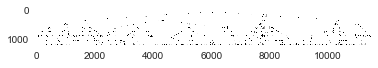

In [37]:
dec_tree_uni = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 8, min_samples_split = 50, min_samples_leaf = 12)
dec_tree_uni.fit(x_train_uni, y_train_uni)
col_names_uni = dec_tree_uni.classes_
feature_names_uni = unisex.columns[0:(unisex.shape[1] - 1)] # the features (attributes) used in the model
visualize_tree(dec_tree_uni, "unisex_decision_tree.png", col_names_uni, feature_names_uni)

Now we predict the other 20% of the data using the decision tree

In [38]:
pred_uni = dec_tree_uni.predict(x_test_uni) # predicting 'dec' for data which the model has not seen yet

### <font color="green">Results</font>

In [39]:
print("Accuracy score: ", metrics.accuracy_score(y_test_uni, pred_uni))

Accuracy score:  0.720760233918


The accuracy of a predictive model has its limitations. It really depends on the randomness of how the data is shuffled and many other factors. A performance matrix contains the Precision and Recall performance of the decision tree, which gives far more information.

In [40]:
print(metrics.classification_report(y_test_uni, pred_uni))

             precision    recall  f1-score   support

          0       0.75      0.78      0.76       790
          1       0.68      0.64      0.66       578

avg / total       0.72      0.72      0.72      1368



percentage "dec = 0" in the unisex data set:  56.67 %
percentage "dec = 1" in the unisex data set:  43.33 %


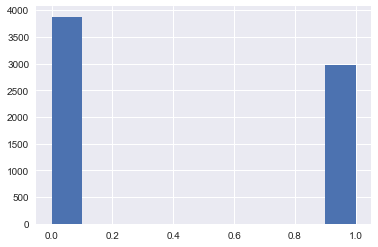

In [41]:
print('percentage "dec = 0" in the unisex data set: ', round((subjects_shuff_uni.loc[subjects_shuff_uni.dec == 0].shape[0] / subjects_shuff_uni.dec.values.shape[0]) * 100, 2), "%")
print('percentage "dec = 1" in the unisex data set: ', round((subjects_shuff_uni.loc[subjects_shuff_uni.dec == 1].shape[0] / subjects_shuff_uni.dec.values.shape[0]) * 100, 2), "%")
plt.hist(subjects_shuff_uni.dec)
plt.show()

The distribution of the binary values 0 and 1 in the <i>dec</i> column is not entirely fair for the subjects as can be seen in the histogram. In conclusive, the subjects expressed in approximately 43% of the dates their wish to see the particular date partner again, and in 57% of the dates they did not see a future with the respective date partner. This is to be expected because in 1.3 the male dec ratio was about 50/50 however female dec ratio was 63/37. The next step is to make some well-tought statements about the performance metrics depicted in the previous set of cells

<b>Unisex Model</b>
The support of this model is (769/(769 + 599))*100% = 56.2%, which is close to the distribution of the dec attribute in the complet data set (56.67%). For both dec = 0 and dec = 1 the <i>precision</i> and <i>recall</i> metrics are going to be evaluated.
* <b>for dec = 0</b> The classifier has a precision of 71% and a recall of 77%. This means that the classifier was able to classify 77% of the records with value 0 for 0, with the correct value of 0. So for 77% of the records the model predicts right for dec = 0. In other words, the classifier misses 23% of the records that should be 0 and classifies 29% of the records as 0 when they are in fact 1.
* <b>for dec = 1</b> The classifier has a precision of 67% and a recall of 60%. This means that the classifier was able to classify 61% of the records with value 0 for 0, with the correct value of 0. So for 60% of the records the model predicts right for dec = 1. In other words, the classifier misses 40% of the records that should be 1 and classifies 33% of the records as 1 when they are in fact 0.

The classifier is slightly better at predicting wheter a date is not wanted to when a date is wanted.

## Speed dating data-set
#### Bart v. Helvert, Remco Surtel & Abdel K. Bokharous - November 2017

### 2.2 Unisex model

The last step in this explorative and predictive analysis of the speed dating event data is an assessment and evaluation of the differences, in terms of both performance and configuration, between the unisex model and the seperate gender models. In task 2.1 the assumption was made that it is not legitimate to build seperate models per gender. As a consequence, a unisex model was build and evaluated (individually). The same parameters and attributes were used in the unisex and the seperate gender models. The next steps is to find differences between the unisex model, and the per-gender model (i.e. different prediction of a specific male subject and specific female partner between the male madoel and the unisex model). 

Before the continuation with a constructive exploration of the differences in the models, the performances of the models is compared. To compare the performance differences, the results of the male and unisex model are compared. Task 2.2 advocates a comparison between the predictions of the male model and the unisex model. It makes, therefore, sense to limit the performance comparison and evaluation also on just the differences between the male model (as a representative of the per-gender model) and the unisex model.

Several arguments have been given why the accuracy of a model should be taken with a grain of salt (i.e. always consider the accuracy in the context of the domain problem and data set characteristics). But it is, however, always an easy performance metric to start with. One can see that the accuracy of the unisex model is around 0.72, while the accuracy of the male model is around 0.73. The stability of the models are, however, apocryphal and somewhat disputable. It is, therefore, disputable to make sound conclusions based of an absolute difference of 0.01. Claiming that the per-gender models are better performance-wise is, therefore, not logically right. Note that in addition, the accuracy of the female model is around 0.716. This makes it an even bolder claim. 

A quick scan over the differences between other performance metrics such as precision and recall shows that there are no extreme differences in those particular metrics between the unisex model and the male model. The only substantial difference is the difference of the precision and recall of <i>dec = 1</i>. It is not a very large difference, but an improvement (in perspective of the male- to unisex-model) of 10% is definitely worth a brief, but constructive discussion.

One can see that the precision (0.74 > 0.68) and recall (0.71 > 0.64) of the male model are both significanly better than the precision and recall of the unisex model. In other words, the male model is better at labelling cases in which the (male) subject expresses his wish to see the particular date partner again, correctly (i.e. with <i>dec = 1</i>). In addition, it does so with a higer precision (labels less records of cases in which the subjects does not want to date the person again, with <i>dec = 1</i>). One could, therefore, claim that the per-gender model is better than the unisex model in the detection of <i>dec = 1</i> cases, and it does so with a higher precision. In other words, one could claim that the per-gender model is better at predicting and recognizing cases in which the male subject wants to date the partner again. One has to be careful with such claims, considering the small difference. In addition, one has to take into account the disputable stability of the models and the difference samples (test sample) on which the performance metrics were collected. The comparison would already be more substantial if model validation techniques such as (k-fold) cross-validation were exploited. 

What would be a <b>possible</b> explanation for this difference between the male and unisex model? The assumption was made that it was not useful to build seperate models per gender. As a consequence, a unisex model was built and evaluated (individually). Even though this difference is not substantial, one could back-up this relatively small improvement due to the fact that there are indeed (small) differences in the cognitive process which constitute the decision making process during a speed date and the fact that the some of these difference were somehow recorded in the attributes which were used in the models and found in the training sample by the male classifier during the training phase. This is a possible explanation, but making this conclusion without actually questioning the context, stability and characteristics of the model would be blatantly wrong. It is, however, always pleasant when one can explain a possible correlation with sound reasoning in the context of the problem domain.

The next step is to find the samples in which the models actually differ, and support the differences by the visualizations which have been produced in this elaborate analyis. The samples can be found by analyzing the differences in the two decision trees. These differences can then be queried in the original dataset to see whether there are actually samples which would satisfy the particular attribute values and/or characteristics.